In [1]:
"""
Generate fancy influenza time-course peptide count plot
"""
# Envirnoment specific variables
MONGO_HOST = 'wl-cmadmin'
MONGO_PORT = 27018
TAX_PORT = 27017

import numpy as np
from Bio import SeqIO
from glob import glob
from itertools import chain
from metaproteomics.file_processing import blazmass_tools
from metaproteomics.analysis.taxonomy import Taxonomy
from metaproteomics import utils

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import FancyBboxPatch, BoxStyle

from collections import defaultdict, OrderedDict
from pymongo import MongoClient
#seqDB = MongoClient(MONGO_HOST, MONGO_PORT).SeqDB_072114.SeqDB_072114
taxonomy = Taxonomy(host="localhost", port=TAX_PORT)
# get all influenza tax ids children (all strains)
influenza_tax = set(taxonomy.get_all_children_taxid(11320))
print(len(influenza_tax))

75710


In [2]:
# Parse influenza protein sequences
parse_gene = lambda x: x.description.split("Gene Symbol:")[1].split('|')[0]
fasta_parser = SeqIO.parse("Anhui.fasta", "fasta")
seq_dict = OrderedDict((parse_gene(x), str(x.seq)) for x in fasta_parser)
prot_names, seqs = zip(*seq_dict.items())
all_seq = (60 * 'x').join(seqs) #join with a len 60 spacer
prot_limits = [(all_seq.index(s),all_seq.index(s)+len(s)) for s in seqs]

### For Compil Influenza:
Searched against compil

In [5]:
# Parse influenza dtaselect-filter files
DTAS_files = glob("compil_influenza/DTASelect-filter_*.txt")
dta_paths = {int(x.rsplit('.')[0].rsplit('_',1)[1]):x for x in DTAS_files}
"""
dta_loci = {sample:list(blazmass_tools.dta_select_parser(f, get_tax=True)) for sample,f in dta_paths.items()}
utils.save(dta_loci,"compil_influenza/dta_loci.pkl.gz")
"""
dta_loci = utils.load("compil_influenza/dta_loci.pkl.gz")
NAME = "compil_influenza"

### For human_influenza
searched against uniprot human and A/Anhui/1/2013

In [12]:
DTAS_files = glob("human_influenza/DTASelect-filter_*.txt")
dta_paths = {int(x.rsplit('.')[0].rsplit('_',1)[1]):x for x in DTAS_files}
"""
dta_loci = {sample:list(blazmass_tools.dta_select_parser(f, get_tax=False)) for sample,f in dta_paths.items()}
for sample, loci in dta_loci.items():
    for locus in loci:
        locus['tax_id'] = [11320] if "influenza" in locus['name'].lower() else [9606]
utils.save(dta_loci,"human_influenza/dta_loci.pkl.gz")
"""
dta_loci = utils.load("human_influenza/dta_loci.pkl.gz")
NAME = "human_influenza"

In [6]:
#%% Generate normalization factors
pep_quant = {k:sum(blazmass_tools.build_pep_quant_dict(v).values()) for k,v in dta_paths.items()}
norm_factor = {k:max(pep_quant.values())/v for k,v in pep_quant.items()} # multiply by this to normalize spectral counts

In [20]:
x={x['name']:x['quantification'] for x in dta_loci[24] if influenza_tax & set(x['tax_id'])}
for k,v in x.items():
    print(k + ';' + str(v))

sp|B3EUR6|PB2_I61A1 Polymerase basic protein 2 OS=Influenza A virus (strain A/Swine/Wisconsin/1/1961 H1N1) GN=PB2 PE=3 SV=1;16
sp|Q0A2H9|RDRP_I83A5 RNA-directed RNA polymerase catalytic subunit OS=Influenza A virus (strain A/Chicken/Pennsylvania/1/1983 H5N2) GN=PB1 PE=3 SV=1;31
sp|Q2ICQ2|RDRP_I72A4 RNA-directed RNA polymerase catalytic subunit OS=Influenza A virus (strain A/Memphis/101/1972 H3N2) GN=PB1 PE=3 SV=1;29
gi|32141423|ref|NP_859036.1| matrix protein 1 [Influenza A virus (A/Hong Kong/1073/99(H9N2))];62
sp|Q20NV3|RDRP_I80AD RNA-directed RNA polymerase catalytic subunit OS=Influenza A virus (strain A/Gull/Minnesota/945/1980 H13N6) GN=PB1 PE=3 SV=1;32
sp|Q30NP4|PA_I75A0 Polymerase acidic protein OS=Influenza A virus (strain A/Beijing/39/1975 H3N2) GN=PA-X PE=3 SV=1;33
sp|A4GBY7|PB2_I77AA Polymerase basic protein 2 OS=Influenza A virus (strain A/Brazil/11/1978 H1N1) GN=PB2 PE=3 SV=1;19
gi|32140168|ref|NP_859039.1| polymerase Pb2 [Influenza A virus (A/Hong Kong/1073/99(H9N2))];19
s

In [7]:
# get influenza peptides from this sample
get_influenza_peptides = lambda loci: set(chain(*[locus['unmod_peptide_seq'] for locus in loci if influenza_tax & set(locus['tax_id'])]))
all_influenza_peptides = set(chain(*[get_influenza_peptides(locus) for locus in dta_loci.values()]))

# Count (spectral count normalized) number of unique peptides mapping to influenza and spectral count sum
def influenze_pep_count(loci, nf):
    peps = get_influenza_peptides(loci) 
    pep_quant = {k:v for k,v in blazmass_tools.build_pep_quant_dict(loci).items() if k in peps}
    return len(peps), sum(pep_quant[p] for p in peps)*nf

{k: influenze_pep_count(loci, round(norm_factor[k])) for k,loci in dta_loci.items()}

{0: (0, 0),
 3: (0, 0),
 7: (18, 59),
 12: (50, 263),
 18: (83, 485),
 24: (101, 550)}

In [8]:
# make peptide -> quantification dict using only influenza peptides, for each sample
influenza_pep_quant = {sample: {k:v for k,v in blazmass_tools.build_pep_quant_dict(loci).items() if k in all_influenza_peptides} 
                       for sample,loci in dta_loci.items()}
print(influenza_pep_quant[7])

{'LLQNSQVFSLIRPNENPAHK': 2, 'SCLPACVYGLAVASGYDFER': 3, 'GIGTMVMELIR': 5, 'EGYSLVGIDPFR': 3, 'ATIMAAFTGNTEGR': 2, 'MCSLMQGSTLPR': 1, 'MVLSAFDER': 3, 'NPGNAEIEDLIFLAR': 2, 'ANFSVIFNRLEALILLR': 3, 'MMESARPEDVSFQGR': 4, 'SCLPACVYGLAVASGYDFEREGYSLVGIDPFR': 2, 'ASAGQVSVQPTFSVQR': 4, 'AMEQMAGSSEQAAEAMEVASQAR': 1, 'ESRNPGNAEIEDLIFLAR': 10, 'SQLVWMACHSAAFEDLR': 3, 'DWLMLIPK': 7, 'EVALSYSTGALASCMGLIYNR': 3, 'GILGFVFTLTVPSER': 1}


In [9]:
# Generate peptide to influenza proteome mapping
def gen_mapping_vector(pep_quant, all_seq):
    # map peptides to influenza protein coding exome
    intensity = defaultdict(list)
    for p in pep_quant:
        assert all_seq.count(p) <= 1, "peptide maps to multiple locations. check this"
        if p not in all_seq:
            continue
        start = all_seq.index(p)
        stop = start + len(p)
        for i in range(start, stop):
            intensity[i].append(pep_quant[p])
    #deal with overlapping regions. don't count the same position twice
    intensity = {k:max(v) for k,v in intensity.items()} 
    intensity_vect = np.zeros(len(all_seq))
    for k,v in intensity.items():
        intensity_vect[k] = v
    return intensity_vect

result = {sample: gen_mapping_vector(pep_quant, all_seq)*norm_factor[sample] for sample,pep_quant in influenza_pep_quant.items()}

In [10]:
result

{0: array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 3: array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 7: array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 12: array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 18: array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 24: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

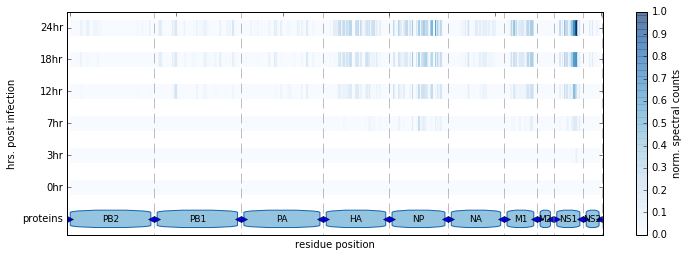

In [18]:
#plot
%matplotlib inline
max_max = max([max(x) for x in result.values()])
scaled_result = {k: v/max_max for k,v in result.items()}

y_dict={0:0, 3:1, 7:2, 12:3, 18:4, 24:5} #hrs to y-axis mapper
fig = pyplot.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('Blues')
for k,v in scaled_result.items():
    s = plt.scatter(list(range(len(v))),np.ones(len(v))*y_dict[k], c=v, vmin=0, vmax=1, 
            cmap=cm, s=200, edgecolors='face', marker='|', alpha = 0.4)
plt.ylabel("hrs. post infection")
plt.xlabel("residue position")
plt.xlim([-30,len(all_seq)+35])
plt.tick_params(axis='x',which='both', bottom='off', labelbottom='off') 
plt.yticks([-1.,  0.,  1.,  2.,  3.,  4.,  5.], 
           ["proteins","0hr","3hr","7hr","12hr","18hr","24hr"])
cb = plt.colorbar()
cb.set_label("norm. spectral counts")

# Add in proteins annotations
for idx,(start,stop) in enumerate(prot_limits):
    plt.plot(start,-1,'b>')
    plt.plot(stop,-1,'b<')
    line, = plt.plot([stop+(60/2)-1]*2, [-50, 100], 'k-', lw=.5, alpha=0.5)
    line.set_dashes([10, 5, 10, 5])
    t = ax.annotate(prot_names[idx], xy=(np.mean([start, stop]), -1), xycoords="data",
                  va="center", ha="center",size=9)
    p_bbox = FancyBboxPatch((start, -1.1), stop-start, 0.2,
                            boxstyle=BoxStyle.Round4(pad=0.2, rounding_size=0.1),
                            fc=cm(0.4),ec=cm(0.8))
    ax.add_patch(p_bbox)
plt.ylim([-1.5,5.5])
plt.show()
fig.savefig(NAME + ".png")
fig.savefig(NAME + ".eps")
fig.savefig(NAME + ".pdf")